# From Pixels to Patterns: A Step-by-Step Guide to CNNs in PyTorch

This interactive Colab notebook will guide you from basic convolution operations to building a VGG-like CNN, with progressively complex datasets and visualizations of internal layer outputs. Ideal for students who already know MLPs and are ready to explore the power of convolutional architectures.

In [5]:
import importlib
import subprocess
import sys
from copy import deepcopy

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torchvision
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchinfo import summary
from torchview import draw_graph
from torchvision import transforms
from torchvision.datasets import MNIST

In [3]:
def ensure_package_installed(package_name, import_name=None):
    """
    Ensures a Python package is installed and imported.

    Args:
        package_name (str): Name used in pip install (e.g., 'torchinfo').
        import_name (str): Module name used in import (e.g., 'torchinfo', 'sklearn').
                           Defaults to package_name.

    Returns:
        module: The imported module object.
    """


    import_name = import_name or package_name

    try:
        return importlib.import_module(import_name)
    except ImportError:
        print(f"Installing '{package_name}'...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
        return importlib.import_module(import_name)

In [ ]:
def get_device_type(verbose: bool = True) -> torch.device:
    """
    Returns the best available device: CUDA → MPS → CPU
    Explicitly separates 'is_built' and 'is_available' checks for both backends.
    """
    if verbose:
        print("Detecting best available device...")

    # ------------------- CUDA -------------------
    cuda_built = torch.version.cuda is not None
    cuda_available = torch.cuda.is_available()

    if cuda_built:
        if cuda_available:
            device = torch.device("cuda")
            if verbose:
                print(f"CUDA → Built: Yes | Available: Yes → Using {device}")
                print(
                    f"   GPU: {torch.cuda.get_device_name(0)} | Count: {torch.cuda.device_count()}"
                )
            return device
        elif verbose:
            print("CUDA → Built: Yes | Available: No (driver/GPU issue)")
    elif verbose:
        print("CUDA → Built: No (CPU-only PyTorch)")

    # ------------------- MPS (Apple Silicon) -------------------
    mps_built = torch.backends.mps.is_built()
    mps_available = torch.backends.mps.is_available()

    if mps_built:
        if mps_available:
            device = torch.device("mps")
            if verbose:
                print(
                    f"MPS → Built: Yes | Available: Yes → Using {device} (Apple Silicon GPU)"
                )
            return device
        elif verbose:
            print("MPS → Built: Yes | Available: No (macOS <12.3 or Intel Mac)")
    elif verbose:
        print("MPS → Built: No (PyTorch compiled without MPS support)")

    # ------------------- CPU Fallback -------------------
    device = torch.device("cpu")
    if verbose:
        print("Falling back to CPU")
    return device

device = get_device_type(True)


Detecting best available device...
CUDA → Built: No (CPU-only PyTorch)
MPS → Built: Yes | Available: Yes → Using mps (Apple Silicon GPU)


In [6]:
torchview = ensure_package_installed('torchview')
torchinfo = ensure_package_installed('torchinfo')

## Load MNIST Dataset
We begin with a simple grayscale dataset: MNIST.

In [7]:
transform = transforms.Compose([
    transforms.ToTensor()
])

trainset_mnist = MNIST(root='./data', train=True, download=True, transform=transform)
testset_mnist = MNIST(root='./data', train=False, download=True, transform=transform)

trainloader_mnist = DataLoader(trainset_mnist, batch_size=64, shuffle=True)
testloader_mnist = DataLoader(testset_mnist, batch_size=64, shuffle=False)

100.0%
100.0%
100.0%
100.0%


## Visualize Sample Images

In [8]:
def show_images(images, labels):
    fig, axs = plt.subplots(1, 6, figsize=(12, 2))
    for i in range(6):
        axs[i].imshow(images[i][0], cmap='gray')
        axs[i].set_title(f"Label: {labels[i].item()}")
        axs[i].axis('off')
    plt.show()



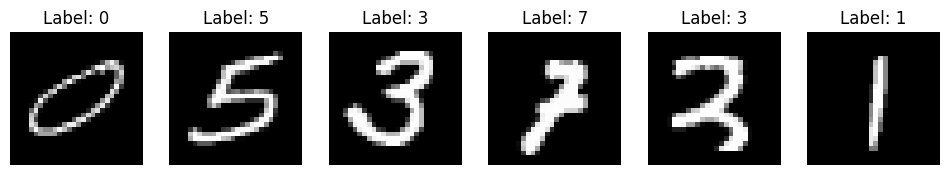

In [9]:
images_mnist, labels_mnist = next(iter(trainloader_mnist))
show_images(images_mnist, labels_mnist)

In [10]:
images_mnist.shape

torch.Size([64, 1, 28, 28])

## Step 1: Simple CNN (1 Conv Layer + Pooling)

In [11]:
class SimpleCNN(nn.Module):
    def __init__(self, input_channels=1, input_size=(28, 28)):
        """
        A simple CNN that adapts to different input sizes and channels.

        Parameters:
        - input_channels (int): Number of channels in the input image (1 for MNIST, 3 for CIFAR-10)
        - input_size (tuple): Tuple of (height, width) of the input image
        """
        super().__init__()
        self.conv = nn.Conv2d(input_channels, out_channels=8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2)

        # Dynamically compute the flattened size after conv + pool
        with torch.no_grad():
            dummy_input = torch.zeros(1, input_channels, *input_size)
            x = self.pool(F.relu(self.conv(dummy_input)))
            self.flattened_size = x.view(1, -1).shape[1]

        self.fc = nn.Linear(self.flattened_size, 10)

    def forward(self, x):
        x = F.relu(self.conv(x))
        self.feature_maps = x.clone() # Save a copy of the output of convolution
        x = self.pool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)


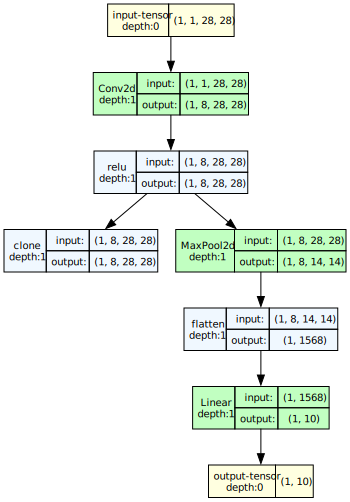

In [12]:
# prompt: Display the architecture of SimpleNet using a library


model_simple = SimpleCNN().to(device)

# Display the model architecture
model_graph = draw_graph(model_simple, input_size=(1, 1, 28, 28), expand_nested=True)
model_graph.visual_graph

In [13]:
summary(SimpleCNN(input_channels=1, input_size=(28, 28)), input_size=(1, 1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN                                [1, 10]                   --
├─Conv2d: 1-1                            [1, 8, 28, 28]            80
├─MaxPool2d: 1-2                         [1, 8, 14, 14]            --
├─Linear: 1-3                            [1, 10]                   15,690
Total params: 15,770
Trainable params: 15,770
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.08
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.06
Estimated Total Size (MB): 0.12

In [14]:
model = SimpleCNN()
conv_weights = model.conv.weight  # shape: [out_channels, in_channels, kernel_h, kernel_w]
conv_bias = model.conv.bias       # shape: [out_channels]
print("Conv Weights:", conv_weights.shape)
print("Conv Bias:", conv_bias.shape)

# If you want the parameters for the first filter (i.e. filter 0):
filter0_weights = conv_weights[0]     # shape: [in_channels, 3, 3]
filter0_bias = conv_bias[0]           # scalar

# Use .numel() to count the number of learnable parameters
filter0_param_count = filter0_weights.numel() + filter0_bias.numel()  # 9 + 1 = 10
print("Filter 0 Param Count:", filter0_param_count)

Conv Weights: torch.Size([8, 1, 3, 3])
Conv Bias: torch.Size([8])
Filter 0 Param Count: 10


In [15]:
total_params = sum(p.numel() for p in model.conv.parameters())
print(f"Total parameters in conv layer: {total_params}")  # Expect 80

# Also confirm shapes
print("Weight shape:", model.conv.weight.shape)  # [8, 1, 3, 3]
print("Bias shape:", model.conv.bias.shape)      # [8]

Total parameters in conv layer: 80
Weight shape: torch.Size([8, 1, 3, 3])
Bias shape: torch.Size([8])


For the final fully connected layer:

Each neuron with ```n``` inputs will need ```n+1``` parameters (one weight for each input + bias).

<div align="center">
<IMG SRC='https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTxNSWgBHZ9Aujox-pMCexn5M5z_--nzjjhmg&s'>
</div>

### Visualize Feature Maps from the First Convolution

In [16]:
def plot_feature_maps_with_original(original, features, title="Feature Maps"):
    original_img = original[0].permute(1, 2, 0).cpu().detach().numpy()
    is_grayscale = original.shape[1] == 1

    num_show = min(4, features.shape[1])
    total = num_show * 2 + 1

    fig, axs = plt.subplots(1, total, figsize=(2 * total, 3))

    for i in range(num_show):
        axs[i].imshow(features[0, i].cpu().detach(), cmap='viridis')
        axs[i].axis('off')

    mid_ax = axs[num_show]
    if is_grayscale:
        mid_ax.imshow(original_img[:, :, 0], cmap='gray')
    else:
        mid_ax.imshow(original_img)
    mid_ax.set_title("Original")
    mid_ax.axis('off')

    for i in range(num_show):
        axs[num_show + 1 + i].imshow(features[0, -num_show + i].cpu().detach(), cmap='viridis')
        axs[num_show + 1 + i].axis('off')

    fig.suptitle(title)
    plt.show()

### Run Model on Sample and Visualize

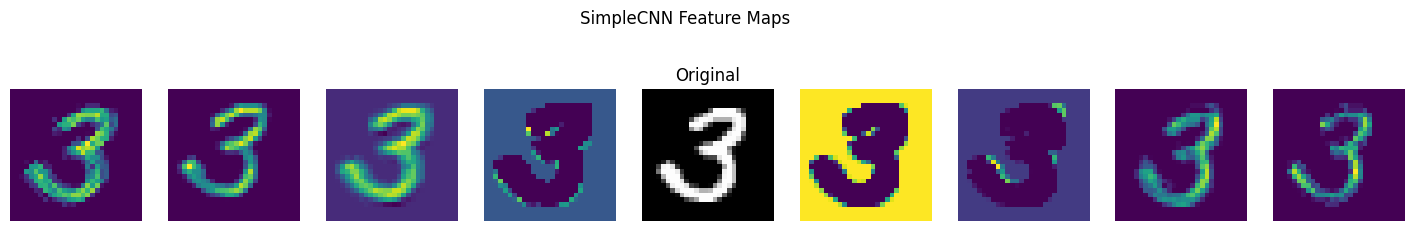

In [17]:
model = SimpleCNN(input_channels=1).to(device)
image = images_mnist[2:3].to(device)
output = model(image)
plot_feature_maps_with_original(image, model.feature_maps, "SimpleCNN Feature Maps")

In [18]:
print("Output shape:", output.shape)
print("Output:", output)

Output shape: torch.Size([1, 10])
Output: tensor([[ 0.0508, -0.1205,  0.0723,  0.0466,  0.0902,  0.2662, -0.0073, -0.2064,
         -0.1918,  0.1242]], device='mps:0', grad_fn=<LinearBackward0>)


## Up Next
We'll add more convolutional layers, explore pooling, and introduce richer datasets like CIFAR-10 and face images. Each step will allow visual inspection of intermediate outputs and their sizes.

> **Optional Exercise:** Try changing the number of output channels in the convolution layer and observe the effect on the feature maps.

## Step 2: Add More Convolutional Layers
Now we'll deepen our network to allow the model to learn more abstract features. We'll also shift to CIFAR-10, a more complex dataset with color images.

In [19]:
class DeeperCNN(nn.Module):
    def __init__(self, input_channels=1, input_size=(28, 28)):
        """
        A deeper CNN model that adapts to different input resolutions and channels.

        Parameters:
        - input_channels (int): Number of input image channels (e.g., 1 for MNIST, 3 for CIFAR-10)
        - input_size (tuple): Height and width of input images (e.g., (28, 28), (32, 32))
        """
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2)

        # Dynamically calculate the flattened size after two convolutions and pooling
        with torch.no_grad():
            dummy_input = torch.zeros(1, input_channels, *input_size)
            x = F.relu(self.conv1(dummy_input))
            x = self.pool(x)
            x = F.relu(self.conv2(x))
            x = self.pool(x)
            self.flattened_size = x.view(1, -1).shape[1]

        self.fc = nn.Linear(self.flattened_size, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        self.feat1 = x.clone()
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        self.feat2 = x.clone()
        x = self.pool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)


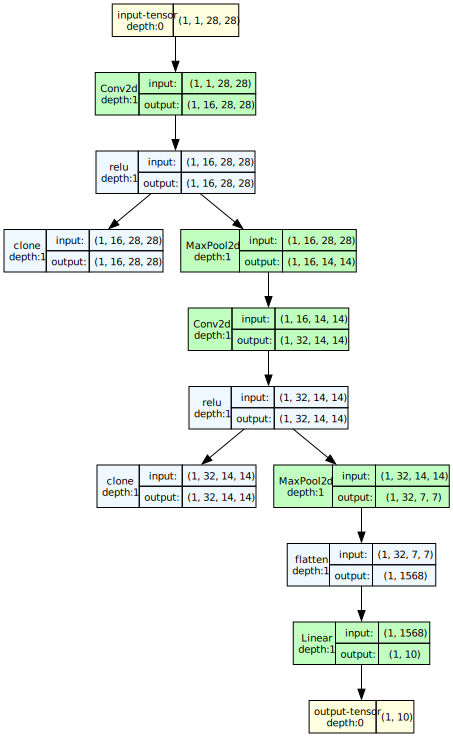

In [20]:
# Display the model architecture
model_new = DeeperCNN(input_channels=1, input_size=(28, 28))
model_graph = draw_graph(model_new, input_size=(1, 1, 28, 28), expand_nested=True)
model_graph.visual_graph

# Note: There are two options for conv2d:

## 1. Each kernel only works on one channel
## 2. Each kernel works on all channels

How will this change the number of learnable parameters?

In [21]:
summary(DeeperCNN(input_channels=1, input_size=(28, 28)), input_size=(1, 1,28,28))

# 160: 16*(3*3*1 +1)
# 4640:  32*( 3*3*16 + 1) , Why not 3*3*16+16 ?

Layer (type:depth-idx)                   Output Shape              Param #
DeeperCNN                                [1, 10]                   --
├─Conv2d: 1-1                            [1, 16, 28, 28]           160
├─MaxPool2d: 1-2                         [1, 16, 14, 14]           --
├─Conv2d: 1-3                            [1, 32, 14, 14]           4,640
├─MaxPool2d: 1-4                         [1, 32, 7, 7]             --
├─Linear: 1-5                            [1, 10]                   15,690
Total params: 20,490
Trainable params: 20,490
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.05
Input size (MB): 0.00
Forward/backward pass size (MB): 0.15
Params size (MB): 0.08
Estimated Total Size (MB): 0.24

<div align="center">
<IMG SRC="https://www.researchgate.net/publication/334974839/figure/fig4/AS:788678381146114@1565046987659/D-convolution-with-filter-size-3x3-49.jpg">
<IMG SRC="https://global.discourse-cdn.com/dlai/optimized/3X/c/2/c2ed4b56ec1a1b464b6b0079ac36a8c0f874723f_2_690x237.png">
</div>

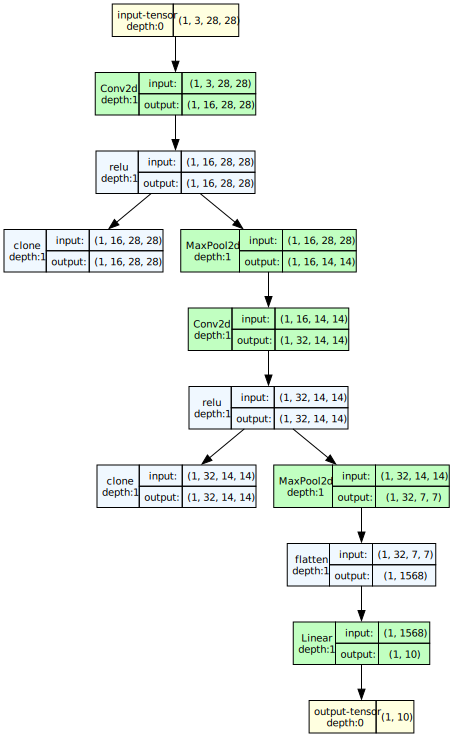

In [22]:
# Display the model architecture
model_new_RGB = DeeperCNN(input_channels=3, input_size=(28, 28))
model_graph = draw_graph(model_new_RGB, input_size=(1, 3, 28, 28), expand_nested=True)
model_graph.visual_graph

In [23]:
summary(DeeperCNN(input_channels=3, input_size=(28, 28)), input_size=(1, 3,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
DeeperCNN                                [1, 10]                   --
├─Conv2d: 1-1                            [1, 16, 28, 28]           448
├─MaxPool2d: 1-2                         [1, 16, 14, 14]           --
├─Conv2d: 1-3                            [1, 32, 14, 14]           4,640
├─MaxPool2d: 1-4                         [1, 32, 7, 7]             --
├─Linear: 1-5                            [1, 10]                   15,690
Total params: 20,778
Trainable params: 20,778
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.28
Input size (MB): 0.01
Forward/backward pass size (MB): 0.15
Params size (MB): 0.08
Estimated Total Size (MB): 0.24

In [24]:
total_params = sum(p.numel() for p in model_new_RGB.conv1.parameters())
print(f"Total parameters in conv1 layer: {total_params}")  # Expect

# Also confirm shapes
print("Weight shape:", model_new_RGB.conv1.weight.shape)
print("Bias shape:", model_new_RGB.conv1.bias.shape)

total_params = sum(p.numel() for p in model_new_RGB.conv2.parameters())
print(f"Total parameters in conv2 layer: {total_params}")  # Expect

# Also confirm shapes
print("Weight shape:", model_new_RGB.conv2.weight.shape)
print("Bias shape:", model_new_RGB.conv2.bias.shape)

Total parameters in conv1 layer: 448
Weight shape: torch.Size([16, 3, 3, 3])
Bias shape: torch.Size([16])
Total parameters in conv2 layer: 4640
Weight shape: torch.Size([32, 16, 3, 3])
Bias shape: torch.Size([32])


In [25]:
transform = transforms.ToTensor()

trainset_cifar = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset_cifar = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader_cifar = DataLoader(trainset_cifar, batch_size=64, shuffle=True)
testloader_cifar = DataLoader(testset_cifar, batch_size=64, shuffle=False)

# Use correct indices for CIFAR subset
subset_indices = list(range(512))  # or however many you want
train_cifar_subset = Subset(trainset_cifar, subset_indices)
trainloader_cifar_subset = DataLoader(train_cifar_subset, batch_size=64, shuffle=True)

images_cifar, labels_cifar = next(iter(trainloader_cifar))

print("Shape of training batch:", images_cifar.shape)

100.0%


Shape of training batch: torch.Size([64, 3, 32, 32])


### Visualize CIFAR-10 Images

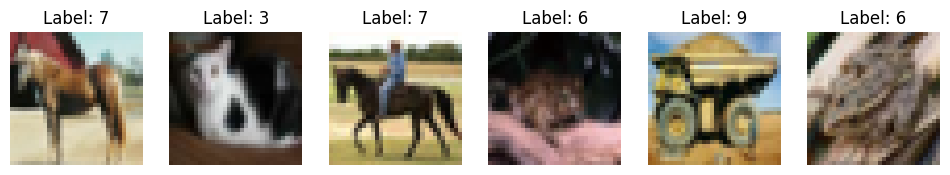

In [28]:

fig, axs = plt.subplots(1, 6, figsize=(12, 2))
for i in range(6):
    axs[i].imshow(images_cifar[i].permute(1, 2, 0))
    axs[i].set_title(f"Label: {labels_cifar[i].item()}")
    axs[i].axis('off')
plt.show()

### Define a Deeper CNN for CIFAR-10

### Run and Visualize Intermediate Feature Maps

## Step 3: Visualize Overfitting on a Tiny Subset
To build intuition for regularization, try training on only 100 samples. Observe the gap between training and test accuracy.

We'll introduce BatchNorm and Dropout only after we understand the symptoms of overfitting.

## Step 4: Train the CNN on a Subset
To keep things fast and interactive, we'll train on a small subset of the dataset and observe the learning process.

In [29]:
# Take a small subset (e.g. 1000 samples)
subset_indices = list(range(100))
train_subset = Subset(trainset_mnist, subset_indices)
trainloader_mnist_subset = DataLoader(train_subset, batch_size=64, shuffle=True)

### Define Training and Evaluation Functions

In [30]:
def train_model(active_model, trainloader, testloader, epochs=5):
    print("Training model structure:")
    print(active_model)  # ADD THIS

    active_model = active_model.to(device)
    optimizer = torch.optim.Adam(active_model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    train_acc, test_acc = [], []

    for epoch in range(epochs):
        active_model.train()
        correct, total = 0, 0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = active_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc.append(correct / total)

        # Evaluate on test set
        active_model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                preds = active_model(inputs).argmax(1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        test_acc.append(correct / total)

        print(f"Epoch {epoch+1}: Train Acc = {train_acc[-1]:.3f}, Test Acc = {test_acc[-1]:.3f}")

    return train_acc, test_acc

In [31]:
def plot_accuracy(train_acc, test_acc):
    plt.plot(train_acc, label='Train Acc')
    plt.plot(test_acc, label='Test Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Test Accuracy')
    plt.legend()
    plt.show()


### Train the SimpleCNN Model on MNIST Subset

Training model structure:
SimpleCNN(
  (conv): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)
Epoch 1: Train Acc = 0.090, Test Acc = 0.105
Epoch 2: Train Acc = 0.170, Test Acc = 0.185
Epoch 3: Train Acc = 0.220, Test Acc = 0.218


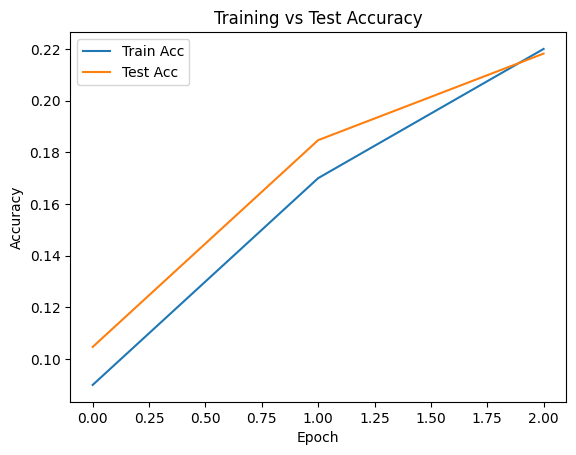

In [32]:
# Reinitialize model to reset weights
model = SimpleCNN(input_channels=1, input_size=(28, 28))

# Save untrained model state for feature map comparison
model_untrained = deepcopy(model)

train_acc, test_acc = train_model(model, trainloader_mnist_subset, testloader_mnist, epochs=3)
plot_accuracy(train_acc, test_acc)

### Compare Feature Maps: Before vs After Training

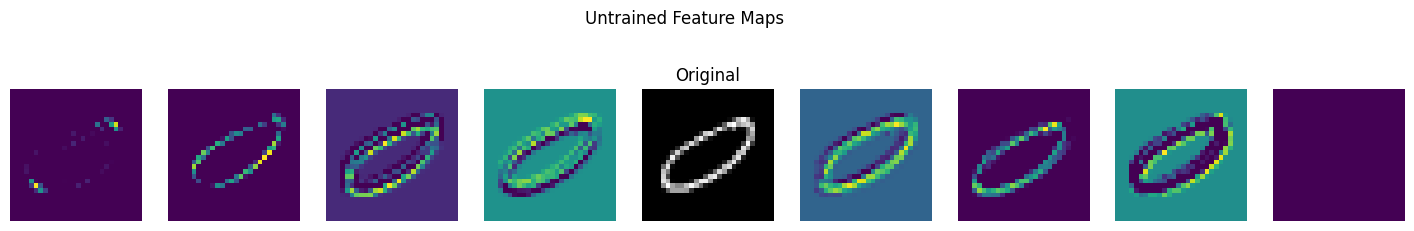

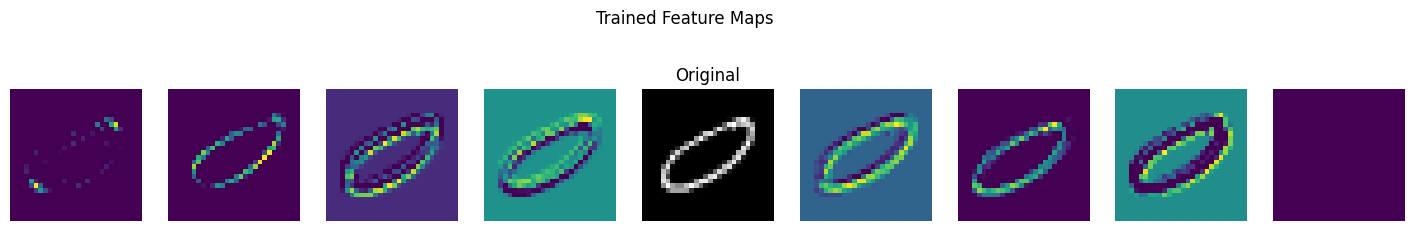

In [34]:
# Choose a sample image
image = images_mnist[0:1]#.to(device)

# Untrained
model_untrained.eval()
with torch.no_grad():
    model_untrained(image)
plot_feature_maps_with_original(image, model_untrained.feature_maps, "Untrained Feature Maps")

# Trained
model.eval()
with torch.no_grad():
    model(image.to(device))
plot_feature_maps_with_original(image, model.feature_maps, "Trained Feature Maps")

Shape of training batch: torch.Size([64, 3, 32, 32])
Training model structure:
DeeperCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1: Train Acc = 0.100, Test Acc = 0.102
Epoch 2: Train Acc = 0.150, Test Acc = 0.103
Epoch 3: Train Acc = 0.170, Test Acc = 0.100
Epoch 4: Train Acc = 0.170, Test Acc = 0.100
Epoch 5: Train Acc = 0.160, Test Acc = 0.100
Epoch 6: Train Acc = 0.160, Test Acc = 0.100
Epoch 7: Train Acc = 0.160, Test Acc = 0.100
Epoch 8: Train Acc = 0.160, Test Acc = 0.100
Epoch 9: Train Acc = 0.160, Test Acc = 0.100
Epoch 10: Train Acc = 0.160, Test Acc = 0.101
Epoch 11: Train Acc = 0.170, Test Acc = 0.107
Epoch 12: Train Acc = 0.220, Test Acc = 0.107
Epoch 13: Train Acc = 0.230, Test Acc = 0.110
Epoch 14: Train Acc 

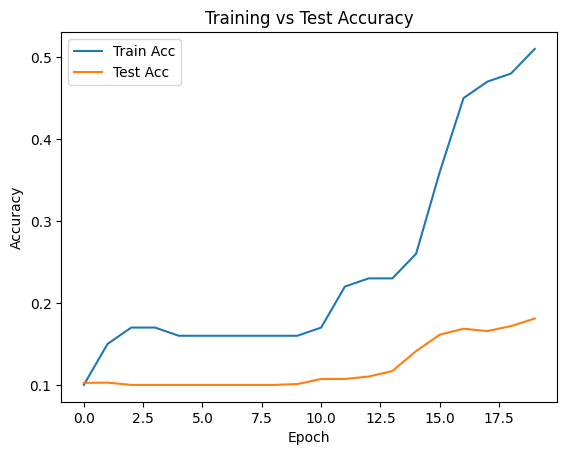

AttributeError: 'DeeperCNN' object has no attribute 'feature_maps'

In [35]:
train_cifar_subset = Subset(trainset_cifar, subset_indices)
trainloader_cifar_subset = DataLoader(train_cifar_subset, batch_size=64, shuffle=True)

# Reinitialize model for CIFAR
# model2 = SimpleCNN(input_channels=3, input_size=(32, 32)).to(device)
model2 = DeeperCNN(input_channels=3, input_size=(32, 32)).to(device)

# Save untrained copy (after sending to device)
model2_untrained = deepcopy(model2)


# Get CIFAR image sample
images_cifar, _ = next(iter(trainloader_cifar_subset))
print("Shape of training batch:", images_cifar.shape)


# Train on CIFAR
train_acc, test_acc = train_model(model2, trainloader_cifar_subset, testloader_cifar, epochs=20)
plot_accuracy(train_acc, test_acc)



image_cifar = images_cifar[0:1].to(device)  # Send image to device too

# Untrained model
model2_untrained.eval()
with torch.no_grad():
    model2_untrained(image_cifar)
plot_feature_maps_with_original(image_cifar, model2_untrained.feature_maps, "Untrained Feature Maps")

# Trained model
model2.eval()
with torch.no_grad():
    model2(image_cifar)
plot_feature_maps_with_original(image_cifar, model2.feature_maps, "Trained Feature Maps")
